# Changes in the 2016.03 Release: the FilterCatalog

This is one of a series of posts highlighting changes (mostly new features) in the 2016.03 (Q1 2016) release of the RDKit.

This one focuses on the `FilterCatalog`: a class introduced in the 2015.09 release that has seen some small improvements for this release and that remains "underdocumented". This is intended to help a bit with that second part.

In [1]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import FilterCatalog
from rdkit.Chem.FilterCatalog import FilterCatalogParams
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from rdkit import rdBase
print(rdBase.rdkitVersion)
import time,gzip
print(time.asctime())

2016.03.1.b1
Fri Apr  8 15:06:12 2016


At a very high level, the `FilterCatalog` allows collections of queries to be used to filter sets of compounds.

The RDKit comes with a number of query sets pre-configured:

In [2]:
FilterCatalogParams.FilterCatalogs.names

{'ALL': rdkit.Chem.rdfiltercatalog.FilterCatalogs.ALL,
 'BRENK': rdkit.Chem.rdfiltercatalog.FilterCatalogs.BRENK,
 'NIH': rdkit.Chem.rdfiltercatalog.FilterCatalogs.NIH,
 'PAINS': rdkit.Chem.rdfiltercatalog.FilterCatalogs.PAINS,
 'PAINS_A': rdkit.Chem.rdfiltercatalog.FilterCatalogs.PAINS_A,
 'PAINS_B': rdkit.Chem.rdfiltercatalog.FilterCatalogs.PAINS_B,
 'PAINS_C': rdkit.Chem.rdfiltercatalog.FilterCatalogs.PAINS_C,
 'ZINC': rdkit.Chem.rdfiltercatalog.FilterCatalogs.ZINC}

Let's look at using one.

I'll start by creating a `FilterCatalog` that using the filters from the `PAINS`, `BRENK`, and `NIH` sets:

In [3]:
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.NIH)

filters = FilterCatalog.FilterCatalog(params)

RDKit WARNING: [15:06:12] WARNING: merging explicit H queries involved in ORs is not supported. This query will not be merged
RDKit WARNING: [15:06:12] WARNING: merging explicit H queries involved in ORs is not supported. This query will not be merged
RDKit WARNING: [15:06:12] WARNING: merging explicit H queries involved in ORs is not supported. This query will not be merged
RDKit WARNING: [15:06:12] WARNING: merging explicit H queries involved in ORs is not supported. This query will not be merged
RDKit WARNING: [15:06:12] WARNING: merging explicit H queries involved in ORs is not supported. This query will not be merged
RDKit WARNING: [15:06:12] WARNING: merging explicit H queries involved in ORs is not supported. This query will not be merged
RDKit WARNING: [15:06:12] WARNING: merging explicit H queries involved in ORs is not supported. This query will not be merged
RDKit WARNING: [15:06:12] WARNING: merging explicit H queries involved in ORs is not supported. This query will not be

*Note* this shows another addition to the 2016.03 release: error messages and warnings from the C++ code now show up in the Jupyter notebook (at least on Linux and the Mac)

And now lets run through a set of compounds until we find a match to one of our filters:

In [4]:
# start with a convenience function that finds a molecule matching the
# FilterCatalog passed in and returns the matching molecule as well
# as the match information
def findMatch(fc):
    inf = gzip.open("../data/malariahts_trainingset.txt.gz") # HTS data from the 2014 TDT challenge
    keep = []
    nReject=0
    inf.readline() # ignore the header line
    for i,line in enumerate(inf):
        splitL = line.strip().split()
        smi = splitL[-1]
        m = Chem.MolFromSmiles(smi)
        if m is None:
            continue
        if fc.HasMatch(m):
            matches = fc.GetMatches(m)
            break
    return m,matches


hzone_anil_di_alk(35)
Baell JB, Holloway GA. New Substructure Filters for Removal of Pan Assay Interference Compounds (PAINS) from Screening Libraries and for Their Exclusion in Bioassays. J Med Chem 53 (2010) 2719D40. doi:10.1021/jm901137j.
PAINS filters (family B)
------------
imine_1
Brenk R et al. Lessons Learnt from Assembling Screening Libraries for Drug Discovery for Neglected Diseases. ChemMedChem 3 (2008) 435-444. doi:10.1002/cmdc.200700139.
unwanted functionality due to potential tox reasons or unfavourable pharmacokinetic properties
------------
Oxygen-nitrogen_single_bond
Brenk R et al. Lessons Learnt from Assembling Screening Libraries for Drug Discovery for Neglected Diseases. ChemMedChem 3 (2008) 435-444. doi:10.1002/cmdc.200700139.
unwanted functionality due to potential tox reasons or unfavourable pharmacokinetic properties
------------


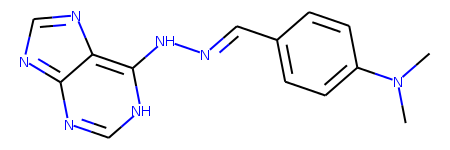

In [5]:
m,matches = findMatch(filters)
for match in matches:
    print(match.GetDescription())
    print(match.GetProp("Reference"))
    print(match.GetProp("Scope"))
    print("------------")
m

Look at the atoms matching a couple of the filters:

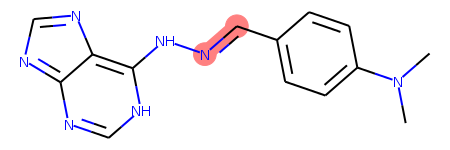

In [6]:
hatoms = [x[1] for x in matches[1].GetFilterMatches(m)[0].atomPairs]
# take advantage of the way the Jupyter notebook integration works:
m.__sssAtoms=hatoms
m

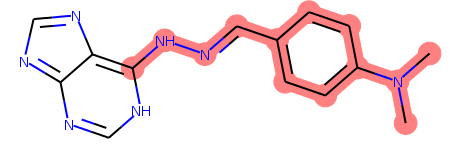

In [7]:
hatoms = [x[1] for x in matches[0].GetFilterMatches(m)[0].atomPairs]
m.__sssAtoms=hatoms
m

In [8]:
m.__sssAtoms=None

We can also create our own filters.
Here's one that catches molecules that have at least two monosubtituted phenyl rings:

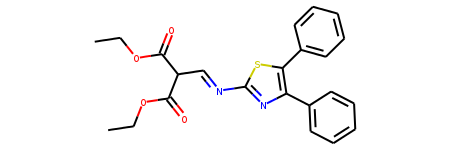

In [9]:
two_phenyls = FilterCatalog.SmartsMatcher("at least two phenyls","[cD3]1[cD2][cD2][cD2][cD2][cD2]1",2)
fc = FilterCatalog.FilterCatalog()
fc.AddEntry(FilterCatalog.FilterCatalogEntry("matcher",two_phenyls))

m,matches = findMatch(fc)
m

We can also combine filters. Here's one that matches molecules with at least two monosubstituted phenyl rings but no thiazole:

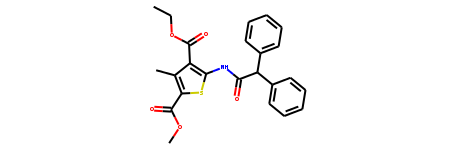

In [10]:
thiazole = FilterCatalog.SmartsMatcher("thiazole","c1sccn1",1)
combined = FilterCatalog.FilterMatchOps.And(two_phenyls,FilterCatalog.FilterMatchOps.Not(thiazole))
fc = FilterCatalog.FilterCatalog()
fc.AddEntry(FilterCatalog.FilterCatalogEntry("matcher",combined))


m,matches = findMatch(fc)
m

Adding exclusions like this is actually even easier using the `ExclusionList` class:

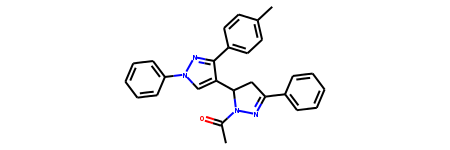

In [11]:
excluder = FilterCatalog.ExclusionList()
excluder.AddPattern(FilterCatalog.SmartsMatcher("thiazole","c1sccn1",1))
excluder.AddPattern(FilterCatalog.SmartsMatcher("thiophene","c1sccc1",1))
excluder.AddPattern(FilterCatalog.SmartsMatcher("piperazine","C1CNCCN1",1))

combined = FilterCatalog.FilterMatchOps.And(two_phenyls,excluder)
fc = FilterCatalog.FilterCatalog()
fc.AddEntry(FilterCatalog.FilterCatalogEntry("matcher",combined))

m,matches = findMatch(fc)
m

As a final example for this post, here's how to define your own filters in Python:

308.406


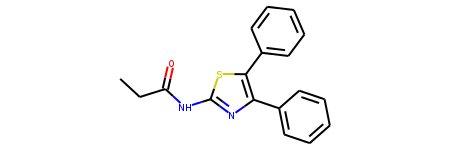

In [12]:
from rdkit.Chem import Descriptors
class MWFilter(FilterCatalog.FilterMatcher):
    def __init__(self, minMw, maxMw):
        FilterCatalog.FilterMatcher.__init__(self, "MW violation")
        self.minMw = minMw
        self.maxMw = maxMw

    def IsValid(self):
        return True

    def HasMatch(self, mol):
        mw=Descriptors.MolWt(mol)
        return self.minMw <= mw <= self.maxMw

# find smallish molecules:
mw = MWFilter(300,400)
combined = FilterCatalog.FilterMatchOps.And(two_phenyls,mw)
fc = FilterCatalog.FilterCatalog()
fc.AddEntry(FilterCatalog.FilterCatalogEntry("matcher",combined))

m,matches = findMatch(fc)
print(Descriptors.MolWt(m))
m

It is important to note that though being able to use Python filters adds a tremendous amount of flexibility, they are pretty slow when compared to pure C++ filters (this is because of the repeated trips across the Python/C++ interface).